<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Распределения-возраста-в-выборке" data-toc-modified-id="Распределения-возраста-в-выборке-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Распределения возраста в выборке</a></span></li><li><span><a href="#Фотографии" data-toc-modified-id="Фотографии-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Фотографии</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
* Контролировать добросовестность кассиров при продаже алкоголя.

*Задача*: Построить модель, которая по фотографии определит приблизительный возраст человека. 

*План действий:*
- Провести исследовательский анализ данных
- Обучить модель
- Проанализировать результаты

## Исследовательский анализ данных

Для начала импортируем все нужные библиотеки и функции.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Conv2D, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

### Загрузка данных

Загрузим данные.

В нашем распоряжении одна папка со всеми изображениями (/final_files) и csv-файл labels.csv с двумя колонками: file_name и real_age.

In [10]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


Теперь загрузим изоображения.



In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Посмотрим сколько всего достпуно изоображений.

In [4]:
len(labels)

7591

### Распределения возраста в выборке

Лучше всего будет посмотреть на распределение с помощью гистограммы.

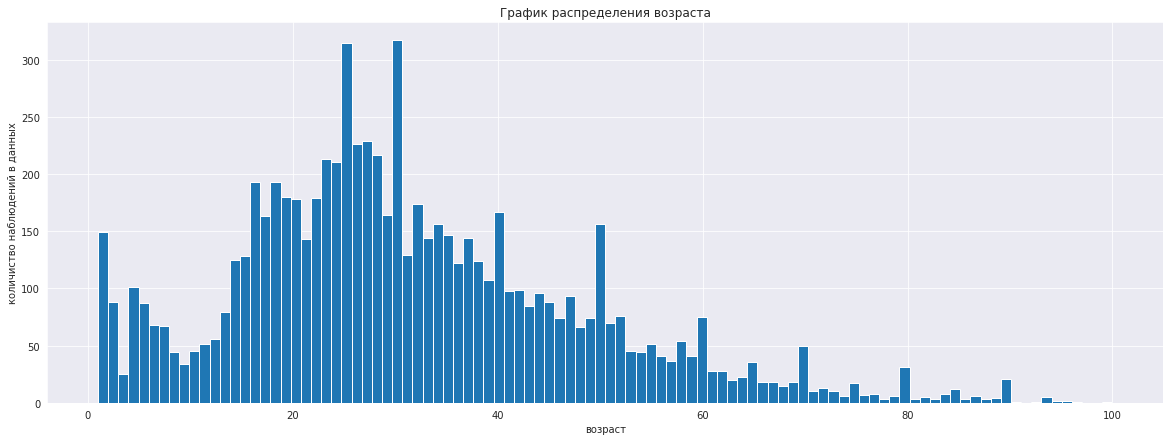

In [13]:
plt.figure(figsize=(20, 7))
labels['real_age'].hist(bins=100)
plt.title('График распределения возраста')
plt.xlabel('возраст')
plt.ylabel('количиство наблюдений в данных')
plt.show()

Наблюдаем что в основном значения лежат в диапазоне от 16 до 40 лет.

### Фотографии

Напечатаем несколько изоображений.

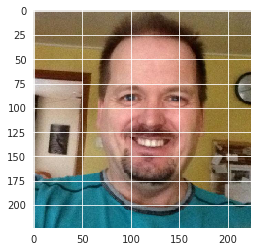

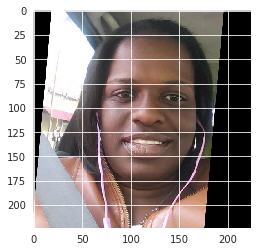

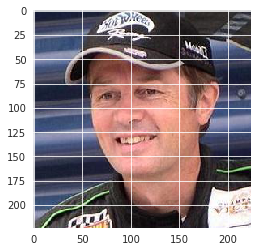

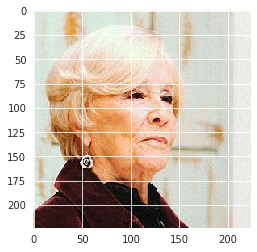

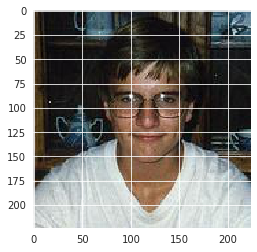

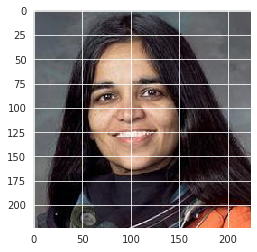

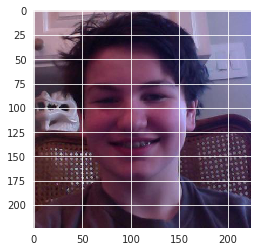

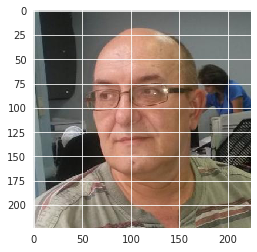

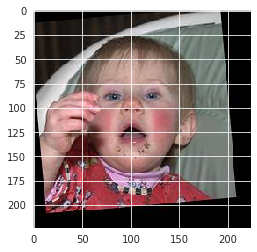

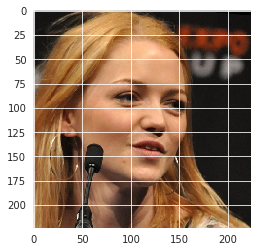

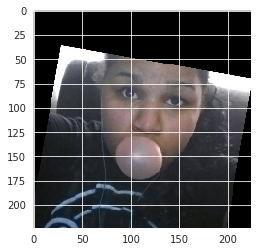

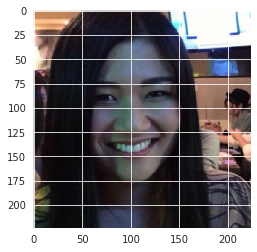

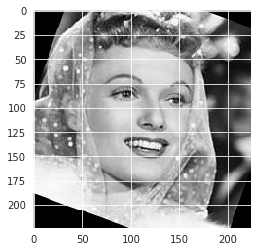

In [6]:
picture, age = train_gen_flow.next()
for i in range(13):
    plt.imshow(picture[i])
    plt.show()

## Обучение модели

Код в этом разделе запускается в специальном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', padding='same', strides=1))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 45s - loss: 220.6529 - mae: 10.9781 - val_loss: 530.3111 - val_mae: 17.9356
Epoch 2/20
178/178 - 37s - loss: 96.9985 - mae: 7.5085 - val_loss: 484.9102 - val_mae: 16.8223
Epoch 3/20
178/178 - 37s - loss: 74.0122 - mae: 6.5519 - val_loss: 323.9594 - val_mae: 13.3550
Epoch 4/20
178/178 - 37s - loss: 59.7545 - mae: 5.8664 - val_loss: 145.4768 - val_mae: 9.1181
Epoch 5/20
178/178 - 37s - loss: 48.5300 - mae: 5.2624 - val_loss: 97.3587 - val_mae: 7.3813
Epoch 6/20
178/178 - 37s - loss: 39.2057 - mae: 4.7787 - val_loss: 87.7446 - val_mae: 6.9685
Epoch 7/20
178/178 - 37s - loss: 32.5924 - mae: 4.3586 - val_loss: 73.8009 - val_mae: 6.4396
Epoch 8/20
178/178 - 37s - loss: 28.1914 - mae: 4.0302 - val_loss: 92.9519 - val_mae: 7.6721
Epoch 9/20
178/178 - 37s - loss: 25.1884 - mae: 3.8085 - val_loss: 71.6383 - val_mae: 6.3041
Epoch 10/20
178/178 - 37s - loss: 21.6245 - mae: 3.5597 - val_loss: 75.0703 - val_mae: 6.5037
Epoch 11/20
178/178 - 37s - loss: 20.2717 - mae: 3.3687 - val_loss: 83.5705 - val_mae: 7.0016
Epoch 12/20
178/178 - 37s - loss: 18.8212 - mae: 3.2843 - val_loss: 77.9765 - val_mae: 6.7880
Epoch 13/20
178/178 - 37s - loss: 17.7445 - mae: 3.2076 - val_loss: 68.8764 - val_mae: 6.1584
Epoch 14/20
178/178 - 37s - loss: 15.0197 - mae: 2.9350 - val_loss: 74.2042 - val_mae: 6.2599
Epoch 15/20
178/178 - 37s - loss: 14.9364 - mae: 2.9167 - val_loss: 77.0296 - val_mae: 6.4895
Epoch 16/20
178/178 - 37s - loss: 13.4505 - mae: 2.8122 - val_loss: 76.4518 - val_mae: 6.4222
Epoch 17/20
178/178 - 37s - loss: 12.8317 - mae: 2.7025 - val_loss: 73.5146 - val_mae: 6.2747
Epoch 18/20
178/178 - 37s - loss: 12.3668 - mae: 2.6633 - val_loss: 71.3924 - val_mae: 6.3801
Epoch 19/20
178/178 - 37s - loss: 11.8314 - mae: 2.6201 - val_loss: 71.5358 - val_mae: 6.4586
Epoch 20/20
178/178 - 37s - loss: 11.7205 - mae: 2.5918 - val_loss: 66.7937 - val_mae: 6.0029

60/60 - 9s - loss: 66.7937 - mae: 6.0029
Test MAE: 6.0029

```

## Анализ обученной модели

Мы получили неплохую модель, которая оценивает возраст человека на фотографии в диапазоне +-6 лет.

Такого качества модели должно хватить, чтобы магазин «Хлеб-Соль» смог правильно сегменитровать покупателей по возрасту и  установить, какие товары лучше предлагать людям разных возрастных групп.

Также модель поможет в проверке недобростовестных продавцов. Так как модель может максимально ошибиться только на 6 лет, то можно сразу не проверять тех покупателей, чей возраст модель определила как больше 24 лет.